## IMPORT OS AND LIBRAY, AND IMPORT THE DATA

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iot-sensors-01:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3715562%2F6438605%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T132242Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dc6bf7a92739de21d35abb0670f83405cfab5fc634a8a5d5480aeec205aed02676efae1bf19f85930e6afd54f0d52811c3dc2c6d517c9e1656652cfc3d11158a08f84117a9cc48cf8b3038ee38d85c0d9aff0b1298457d42ed72c280100404a30055ac9b24573bb8c3fc6be1d043011954fc8fea155181e542772d0e09a0cce774d7b7d760c53e91b80986813fc66db70b84f7b358cd262a8c3874eebc1b45e7a245c3a437d42b210e0a81028002f20af1b58bed5ac8cd753b50f05072cfedfb7f33ac2ee47392b0e45037c800a400492f3ee3411bd790e95b62be8e3a6c7b181cd24bd8c60f5b010db79610a16e487cd05ba5f2fd3ff71f55f9dc1298f2440'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10785213 bytes downloaded
Downloaded and uncompressed: iot-sensors-01
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iot-sensors-01/Heat_index.csv
/kaggle/input/iot-sensors-01/Sensors_data.csv
/kaggle/input/iot-sensors-01/Temperature.csv
/kaggle/input/iot-sensors-01/Humidity.csv


## EXPLORE DATA ANAYLSIS

In [ ]:
df_temp = pd.read_csv('/kaggle/input/iot-sensors-01/Temperature.csv')
df_temp = df_temp.rename(columns={"_value": df_temp['_field'][0]})
df_temp = df_temp.drop(['Unnamed: 0', 'result','table','_start','_stop','_measurement','_field'], axis=1)
df_temp

,_time,Temperature
0,2022-04-13T21:38:00Z,26.800000
1,2022-04-13T21:39:00Z,26.800000
2,2022-04-13T21:40:00Z,26.800000
3,2022-04-13T21:41:00Z,26.850000
4,2022-04-13T21:42:00Z,26.883333
...,...,...
385867,2023-01-20T01:12:00Z,21.000000
385868,2023-01-20T01:13:00Z,21.000000
385869,2023-01-20T01:14:00Z,21.000000
385870,2023-01-20T01:15:00Z,21.000000


In [ ]:
df_hum = pd.read_csv('/kaggle/input/iot-sensors-01/Humidity.csv')
df_hum = df_hum.rename(columns={"_value": df_hum['_field'][0]})
df_hum = df_hum.drop(['Unnamed: 0', 'result','table','_start','_stop','_measurement','_field'], axis=1)
df_hum

,_time,Humidity
0,2022-04-13T21:38:00Z,32.400000
1,2022-04-13T21:39:00Z,32.433333
2,2022-04-13T21:40:00Z,32.100000
3,2022-04-13T21:41:00Z,31.916667
4,2022-04-13T21:42:00Z,31.716667
...,...,...
385867,2023-01-20T01:12:00Z,46.133333
385868,2023-01-20T01:13:00Z,46.100000
385869,2023-01-20T01:14:00Z,46.266667
385870,2023-01-20T01:15:00Z,46.033333


In [ ]:
df_heat = pd.read_csv('/kaggle/input/iot-sensors-01/Heat_index.csv')
df_heat = df_heat.rename(columns={"_value": df_heat['_field'][0]})
df_heat = df_heat.drop(['Unnamed: 0', 'result','table','_start','_stop','_measurement','_field'], axis=1)
df_heat

,_time,Heat_index
0,2022-04-13T21:38:00Z,26.389790
1,2022-04-13T21:39:00Z,26.391128
2,2022-04-13T21:40:00Z,26.377855
3,2022-04-13T21:41:00Z,26.401618
4,2022-04-13T21:42:00Z,26.414282
...,...,...
385867,2023-01-20T01:12:00Z,20.359950
385868,2023-01-20T01:13:00Z,20.359080
385869,2023-01-20T01:14:00Z,20.363430
385870,2023-01-20T01:15:00Z,20.357340


In [ ]:
df = pd.concat([df_heat, df_hum.drop(['_time'], axis=1)], axis=1)
df = pd.concat([df, df_temp.drop(['_time'], axis=1)], axis=1)
df

,_time,Heat_index,Humidity,Temperature
0,2022-04-13T21:38:00Z,26.389790,32.400000,26.800000
1,2022-04-13T21:39:00Z,26.391128,32.433333,26.800000
2,2022-04-13T21:40:00Z,26.377855,32.100000,26.800000
3,2022-04-13T21:41:00Z,26.401618,31.916667,26.850000
4,2022-04-13T21:42:00Z,26.414282,31.716667,26.883333
...,...,...,...,...
385867,2023-01-20T01:12:00Z,20.359950,46.133333,21.000000
385868,2023-01-20T01:13:00Z,20.359080,46.100000,21.000000
385869,2023-01-20T01:14:00Z,20.363430,46.266667,21.000000
385870,2023-01-20T01:15:00Z,20.357340,46.033333,21.000000


In [ ]:
df.describe()

,Heat_index,Humidity,Temperature
count,385872.000000,385872.000000,385872.000000
mean,23.096529,52.172995,23.350587
std,2.657446,11.013673,2.558366
min,15.753450,17.983333,16.400000
25%,21.541057,45.350000,21.733333
50%,23.203913,53.183333,23.366667
75%,25.036140,59.200000,25.200000
max,30.089642,96.300000,29.933333


In [ ]:
df.isnull().sum()/len(df)

_time          0.0
Heat_index     0.0
Humidity       0.0
Temperature    0.0
dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385872 entries, 0 to 385871
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   _time        385872 non-null  object 
 1   Heat_index   385872 non-null  float64
 2   Humidity     385872 non-null  float64
 3   Temperature  385872 non-null  float64
dtypes: float64(3), object(1)
memory usage: 11.8+ MB


In [ ]:
df.drop(columns=['_time'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385872 entries, 0 to 385871
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Heat_index   385872 non-null  float64
 1   Humidity     385872 non-null  float64
 2   Temperature  385872 non-null  float64
dtypes: float64(3)
memory usage: 8.8 MB


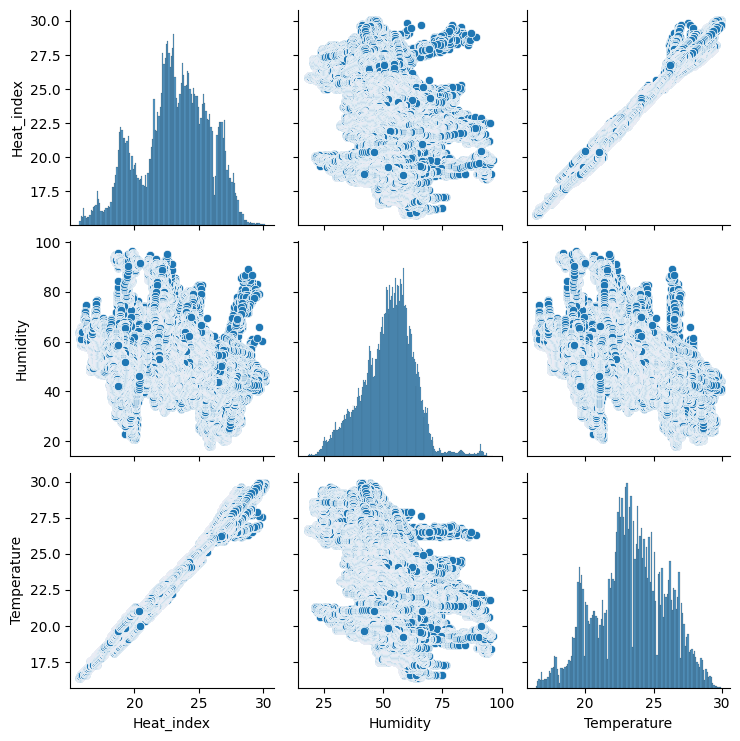

In [ ]:
sns.pairplot(df)

Text(0, 0.5, 'Temperature')

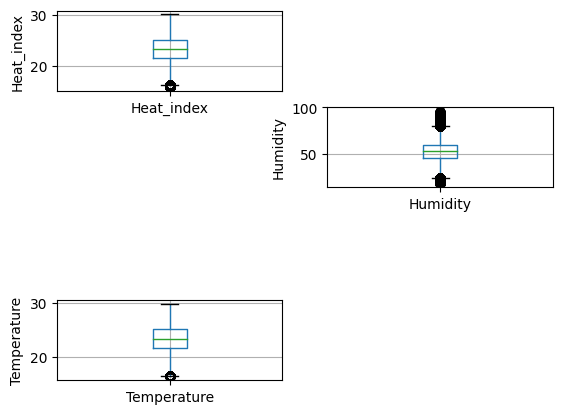

In [ ]:
plt.subplot(4, 2, 1)
fig = df.boxplot(column='Heat_index')
fig.set_title('')
fig.set_ylabel('Heat_index')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='Humidity')
fig.set_title('')
fig.set_ylabel('Humidity')


plt.subplot(4, 2, 7)
fig = df.boxplot(column='Temperature')
fig.set_title('')
fig.set_ylabel('Temperature')



Text(0, 0.5, 'appears as much')

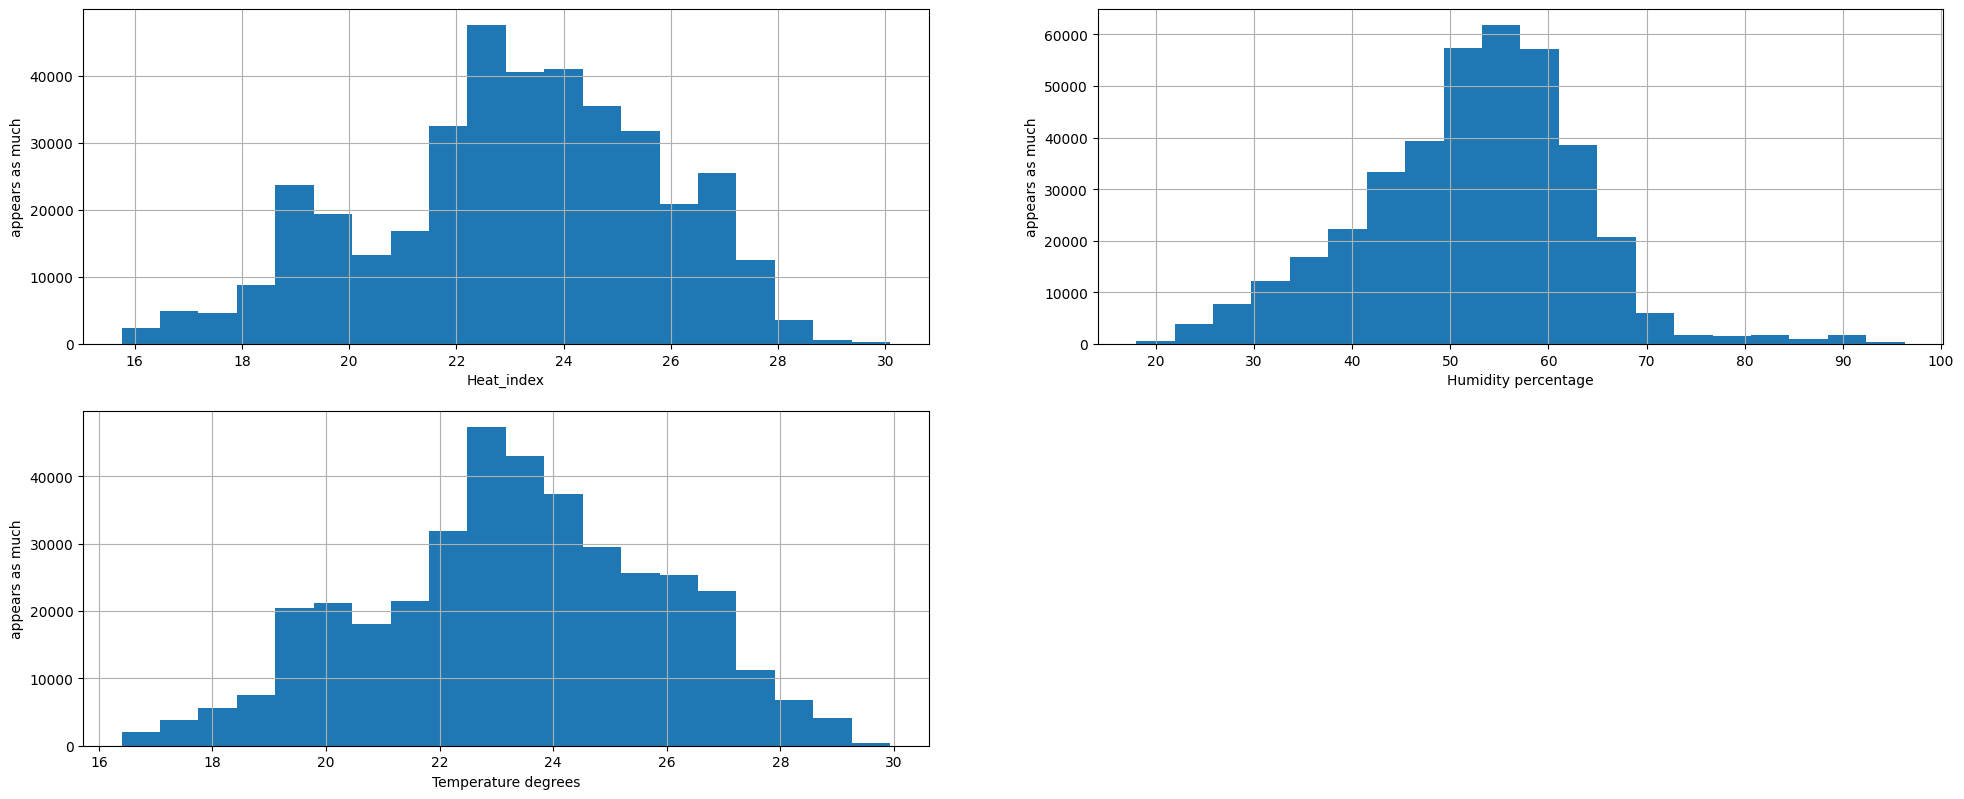

In [ ]:
plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df['Heat_index'].hist(bins=20)
fig.set_xlabel('Heat_index')
fig.set_ylabel('appears as much')


plt.subplot(4, 2, 2)
fig = df['Humidity'].hist(bins=20)
fig.set_xlabel('Humidity percentage')
fig.set_ylabel('appears as much')


plt.subplot(4, 2, 3)
fig = df['Temperature'].hist(bins=20)
fig.set_xlabel('Temperature degrees')
fig.set_ylabel('appears as much')

## Declare feature vector and target variable

In [ ]:
X = df.drop(['Heat_index'], axis=1)

y = df['Heat_index']

## Split data into separate training and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train.shape, X_test.shape

((308697, 2), (77175, 2))

## Feature Scaling

In [ ]:
cols = X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

,Humidity,Temperature
count,3.086970e+05,3.086970e+05
mean,-4.823543e-16,-1.777410e-16
std,1.000002e+00,1.000002e+00
min,-3.104672e+00,-2.714064e+00
25%,-6.216357e-01,-6.361795e-01
50%,9.104573e-02,6.975155e-03
75%,6.372835e-01,7.230380e-01
max,4.005498e+00,2.571782e+00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_iris

# Load dataset (contoh menggunakan Iris dataset)
iris = load_iris()
X = iris.data
y = iris.target

In [ ]:
# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Membuat model SVC dan melatihnya
svc = SVC()
svc.fit(X_train, y_train)


SVC()

In [ ]:
# Memprediksi kelas untuk data uji
y_pred = svc.predict(X_test)

In [ ]:
# Evaluasi performa model (opsional)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


## Run SVM with default hyperparameters

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 1.0000


In [ ]:
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


Model accuracy score with rbf kernel and C=100.0 : 1.0000


In [ ]:
svc = SVC(C=100.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print('Model accuracy score with rbf kernel and C=100.0: {0:0.4f}'.format(accuracy))


Model accuracy score with rbf kernel and C=100.0: 1.0000
